<a href="https://colab.research.google.com/github/Kavjar/NeuralNetworks/blob/main/homework01.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Import neccessary packages and functions:

In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import itertools


from sklearn import datasets
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.model_selection import learning_curve
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error, mean_absolute_percentage_error
from tabulate import tabulate
from keras.optimizer_experimental.adam import Adam
from keras.optimizer_experimental.sgd import SGD
from keras.optimizer_experimental.rmsprop import RMSprop
from keras.models import Sequential
from keras.layers import Dense, Activation
from keras.backend import mean

# Regression problem

Dataset generation and data manipulation

In [2]:
x, y = datasets.make_friedman1(n_samples=150000, n_features=10, noise=0.1, random_state=None)

#to prevent nan loss
x /= 2 * np.max(x)
y /= 2 * np.max(y)

In [3]:
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=1)

# Linear Regression model

Create Linear model and train it

In [4]:
LR_model = LinearRegression()
LR_history = LR_model.fit(X_train, y_train)
print(LR_model.score(X_train, y_train), LR_model.score(X_test, y_test))

0.7549083739012783 0.7483065460758825


Use model to predict test data

In [5]:
y_pred = LR_model.predict(X_test)
y_pred

array([0.38529838, 0.16008236, 0.27162465, ..., 0.06553023, 0.30506299,
       0.24791192])

In [6]:
train_sizes, train_scores, validation_scores = learning_curve(LR_model, x, y, cv=8, shuffle=True,
                                                              train_sizes=[2, 10, 20, 50, 100, 2500, 10000, 15000])
train_scores_mean = train_scores.mean(axis = 1)
validation_scores_mean = validation_scores.mean(axis = 1)

Plot learning curves

(0.0, 1.0)

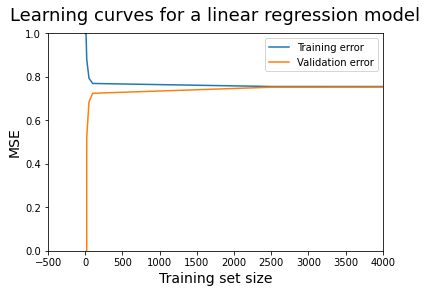

In [7]:
plt.plot(train_sizes, train_scores_mean, label = 'Training error')
plt.plot(train_sizes, validation_scores_mean, label = 'Validation error')
plt.ylabel('MSE', fontsize = 14)
plt.xlabel('Training set size', fontsize = 14)
plt.title('Learning curves for a linear regression model', fontsize = 18, y = 1.03)
plt.legend()
plt.xlim(-500, 4000)
plt.ylim(0,1)

In [8]:
# The coefficients
print("Coefficients: \n", LR_model.coef_)

Coefficients: 
 [ 2.30515411e-01  2.30306698e-01  3.31316159e-04  3.41520715e-01
  1.70991712e-01 -1.30084375e-03  6.09704114e-04  9.87273616e-05
  1.49466347e-03 -2.29910579e-03]


In [9]:
y_pred_train = LR_model.predict(X_train)

R2_train = r2_score(y_train, y_pred_train)
R2_test = r2_score(y_test, y_pred)

MSE_train = mean_squared_error(y_train, y_pred_train)
MSE_test = mean_squared_error(y_test, y_pred)

MAE_train = mean_absolute_error(y_train, y_pred_train)
MAE_test = mean_absolute_error(y_test, y_pred)

MAPE_train = mean_absolute_error(y_train, y_pred_train)
MAPE_test = mean_absolute_error(y_test, y_pred)

data = [["R2", R2_train, R2_test],
        ["MSE", MSE_train, MSE_test],
        ["MAE", MAE_train, MAE_test],
        ["MAPE", MAPE_train, MAPE_test]]
#define header names
col_names = ["Metric", "Train data", "Test data"]

print(tabulate(data, headers=col_names, tablefmt="grid"))

+----------+--------------+-------------+
| Metric   |   Train data |   Test data |
+==========+==============+=============+
| R2       |   0.754908   |  0.748307   |
+----------+--------------+-------------+
| MSE      |   0.00171137 |  0.00174606 |
+----------+--------------+-------------+
| MAE      |   0.031785   |  0.0320504  |
+----------+--------------+-------------+
| MAPE     |   0.031785   |  0.0320504  |
+----------+--------------+-------------+


Now it’s important to notice that adding more training data points won’t lead to significantly better models. So we need to try something else, like switching to an algorithm that can build more complex models.

# DNN model

Since regression problem does not have any classes, so there is no accuracy metric. For this reason we will use MSE(mean squared error) as a custom metric instead.

The DNN class contains all information about current DNN model including model itself, number of hidden layers, optimizer, learning rate and history of already trained model.

In [10]:
def MSE(y_true, y_pred):
    return mean(pow(y_pred/y_true - 1, 2))


def create_dnn_model(num_of_hidden_layers, optimizer, lr):
    model = Sequential()
    model.add(Dense(20, activation="relu", input_dim=10))
    for i in range(num_of_hidden_layers - 1):
        model.add(Dense(15, activation="relu"))
    model.add(Dense(1))

    opt = optimizer(learning_rate=lr)
    model.compile(loss="mean_squared_error", optimizer=opt, metrics=[MSE])
    return model, opt


class DNN:
    def __init__(self, hl_num, opt, lr, history=None):
        model, optimizer = create_dnn_model(hl_num, opt, lr)
        self.hl_num = str(hl_num)
        self.opt = optimizer.name
        self.lr = str(lr)
        self.model = model
        self.history = history

Using itertools module we are generating all combinations of model hyperparameters(hidden_layers, optimizers and learning rates.

In [11]:
layers = [1, 5, 25]
OPTs = [SGD, RMSprop, Adam]
learning_rates = [0.1, 0.01, 0.001]
hyper_parameters = [layers, OPTs, learning_rates]

DNNs = []
all_dnn_combinations = list(itertools.product(*hyper_parameters))
for hp in all_dnn_combinations:
    DNNs.append(DNN(hp[0], hp[1], hp[2]))

In [12]:
BATCH_SIZE = 150
EPOCHS = 10
i = 1
for dnn in DNNs:
    print(f"{i}: {dnn.hl_num} + {dnn.opt} + {dnn.lr}")
    dnn.history = dnn.model.fit(X_train, y_train,
                                batch_size=BATCH_SIZE,
                                epochs=EPOCHS,
                                verbose=1,
                                validation_split=0.2,
                                shuffle=True)
    i += 1

1: 1 + SGD + 0.1
Epoch 1/10
640/640 [==============================] - 5s 7ms/step - loss: 0.0056 - MSE: 0.3339 - val_loss: 0.0025 - val_MSE: 0.1346
Epoch 2/10
640/640 [==============================] - 1s 2ms/step - loss: 0.0021 - MSE: 0.0900 - val_loss: 0.0018 - val_MSE: 0.0726
Epoch 3/10
640/640 [==============================] - 2s 3ms/step - loss: 0.0018 - MSE: 0.0677 - val_loss: 0.0017 - val_MSE: 0.0696
Epoch 4/10
640/640 [==============================] - 1s 2ms/step - loss: 0.0017 - MSE: 0.0633 - val_loss: 0.0017 - val_MSE: 0.0661
Epoch 5/10
640/640 [==============================] - 1s 2ms/step - loss: 0.0017 - MSE: 0.0611 - val_loss: 0.0016 - val_MSE: 0.0632
Epoch 6/10
640/640 [==============================] - 1s 2ms/step - loss: 0.0016 - MSE: 0.0591 - val_loss: 0.0016 - val_MSE: 0.0569
Epoch 7/10
640/640 [==============================] - 1s 2ms/step - loss: 0.0016 - MSE: 0.0574 - val_loss: 0.0016 - val_MSE: 0.0576
Epoch 8/10
640/640 [==============================] - 1s 2m

Function for prediction one target:

In [13]:
def predict(model):
    y_pred = model.predict(X_test)
    y_pred_train = model.predict(X_train)
    return y_pred, y_pred_train

This function calculates all 3 metrics for current model prediction: 

In [14]:
def calc_metrics(prediction):
    y_pred, y_pred_train = prediction[0], prediction[1]
    R2_train = r2_score(y_train, y_pred_train)
    R2_test = r2_score(y_test, y_pred)

    MSE_train = mean_squared_error(y_train, y_pred_train)
    MSE_test = mean_squared_error(y_test, y_pred)

    MAE_train = mean_absolute_error(y_train, y_pred_train)
    MAE_test = mean_absolute_error(y_test, y_pred)

    MAPE_train = mean_absolute_error(y_train, y_pred_train)
    MAPE_test = mean_absolute_error(y_test, y_pred)
    return [R2_train, R2_test, MSE_train, MSE_test, MAE_train, MAE_test, MAPE_train, MAPE_test]

In [15]:
data, iterator = [], 1
for dnn in DNNs:
    # print(iterator)
    dnn_name = f"{dnn.hl_num}hl + {dnn.opt} + {dnn.lr}lr"
    metrics = [dnn_name]
    metrics += calc_metrics(predict(dnn.model))
    data.append(metrics)
    # iterator += 1


#define header names
col_names = ["NAME", "R2_train", "R2_test", "MSE_train", "MSE_test", "MAE_train", "MAE_test", "MAPE_train", "MAPE_test"]

print(tabulate(data, headers=col_names, tablefmt="grid"))

+--------------------------+--------------+--------------+-------------+-------------+-------------+------------+--------------+-------------+
| NAME                     |     R2_train |      R2_test |   MSE_train |    MSE_test |   MAE_train |   MAE_test |   MAPE_train |   MAPE_test |
+==========================+==============+==============+=============+=============+=============+============+==============+=============+
| 1hl + SGD + 0.1lr        |  0.795891    |  0.789414    | 0.00142521  | 0.00146088  |  0.0285862  | 0.0289027  |   0.0285862  |  0.0289027  |
+--------------------------+--------------+--------------+-------------+-------------+-------------+------------+--------------+-------------+
| 1hl + SGD + 0.01lr       |  0.698049    |  0.692725    | 0.0021084   | 0.00213164  |  0.035577   | 0.0357425  |   0.035577   |  0.0357425  |
+--------------------------+--------------+--------------+-------------+-------------+-------------+------------+--------------+-------------+

Lets find out the lowest MSE:

In [38]:
mse_test = np.array(data)[:,4].astype(float)
minim = np.amin(mse_test)
result = np.where(mse_test == minim)
print("The lowest MSE:", minim)
print("Model:", data[result[0][0]][0])

The lowest MSE: 1.5557312228172055e-05
Model: 5hl + Adam + 0.01lr


In [34]:
print(DNNs[0].history.history.keys())

dict_keys(['loss', 'MSE', 'val_loss', 'val_MSE'])


In [50]:
def learning_curves_template(pltt, data, metric):
    pltt.plot(data.history.history[metric])
    pltt.plot(data.history.history[f"val_{metric}"])
    pltt.set_title(metric + f"(lr={data.lr})", fontstyle="italic")
    pltt.legend(["train", "test"], loc="upper right")
    if metric == "MSE":
        pltt.set_facecolor("#C5FAD5")
    else:
        pltt.set_facecolor("#FFFFD2")
        pltt.grid(c="#989ea6")

In [51]:
def build_learning_curves_family(dnns_fam):
    hl_num = dnns_fam[0].hl_num
    print("*" * 50)
    print(f"DNNs with {hl_num} hidden_layers")
    print("*" * 50)
    with plt.style.context("seaborn-darkgrid"):
        fig, axes = plt.subplots(3, 6, figsize=(25,13))
        counter = 0
        for i in range(3):
            for j in range(0, 6, 2):
                learning_curves_template(axes[i, j], dnns_fam[counter], "MSE")
                learning_curves_template(axes[i, j + 1], dnns_fam[counter], "loss")
                counter += 1
                

                
    plt.setp(axes[-1, :], xlabel="epoch")
    plt.setp(axes[::, 0], ylabel="RMSprop")
    plt.setp(axes[::2, 0], ylabel="Adam")
    plt.setp(axes[::3, 0], ylabel="SGD")
    plt.show()

Plot learning curves

**************************************************
DNNs with 1 hidden_layers
**************************************************


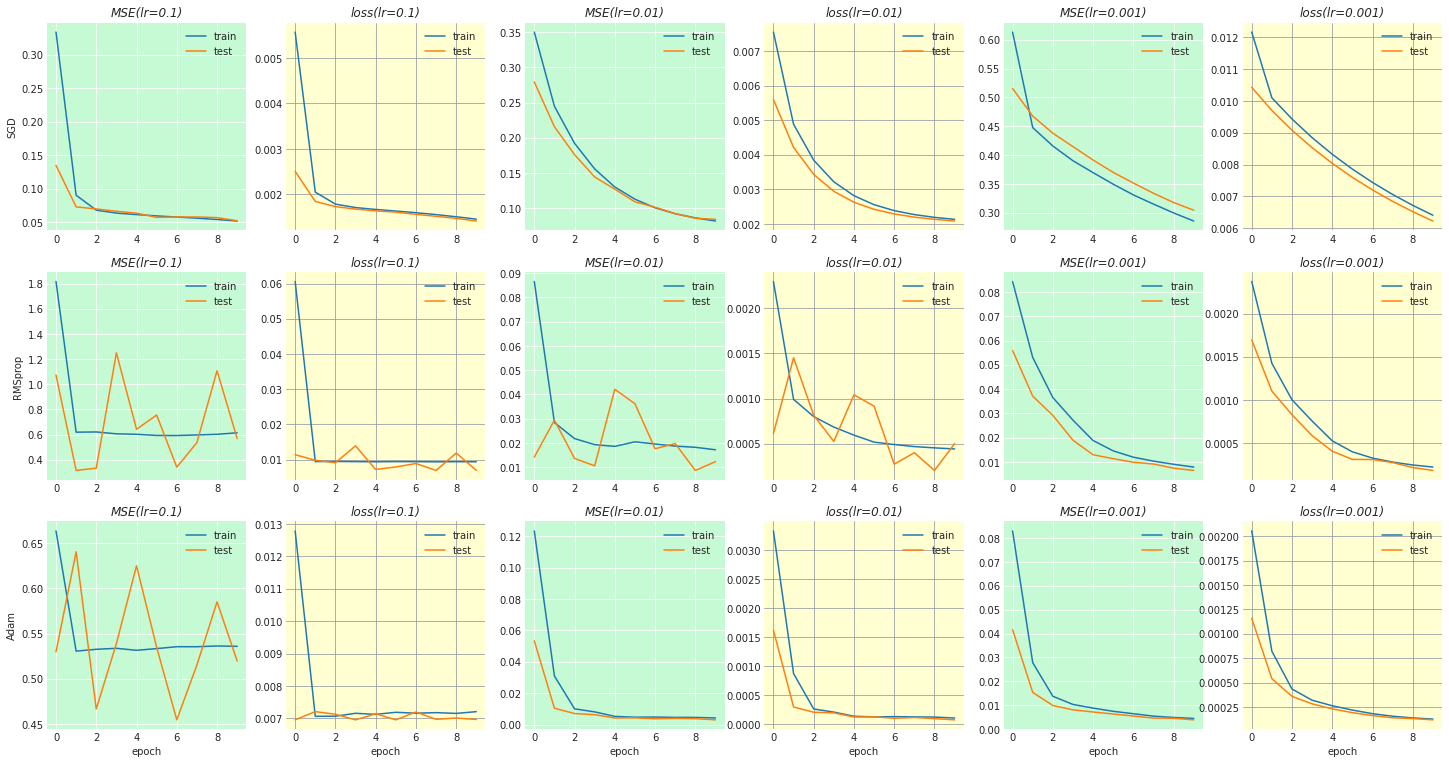

**************************************************
DNNs with 5 hidden_layers
**************************************************


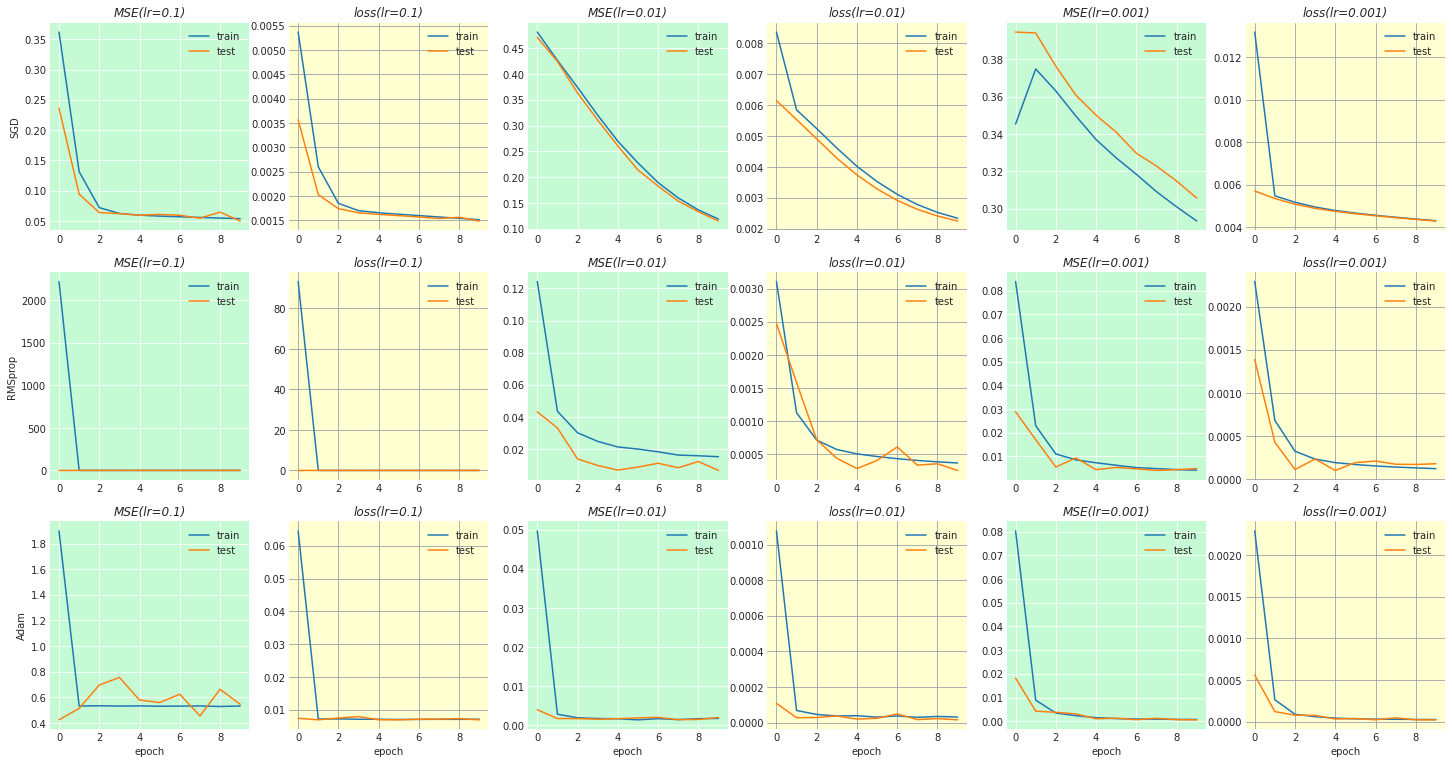

**************************************************
DNNs with 25 hidden_layers
**************************************************


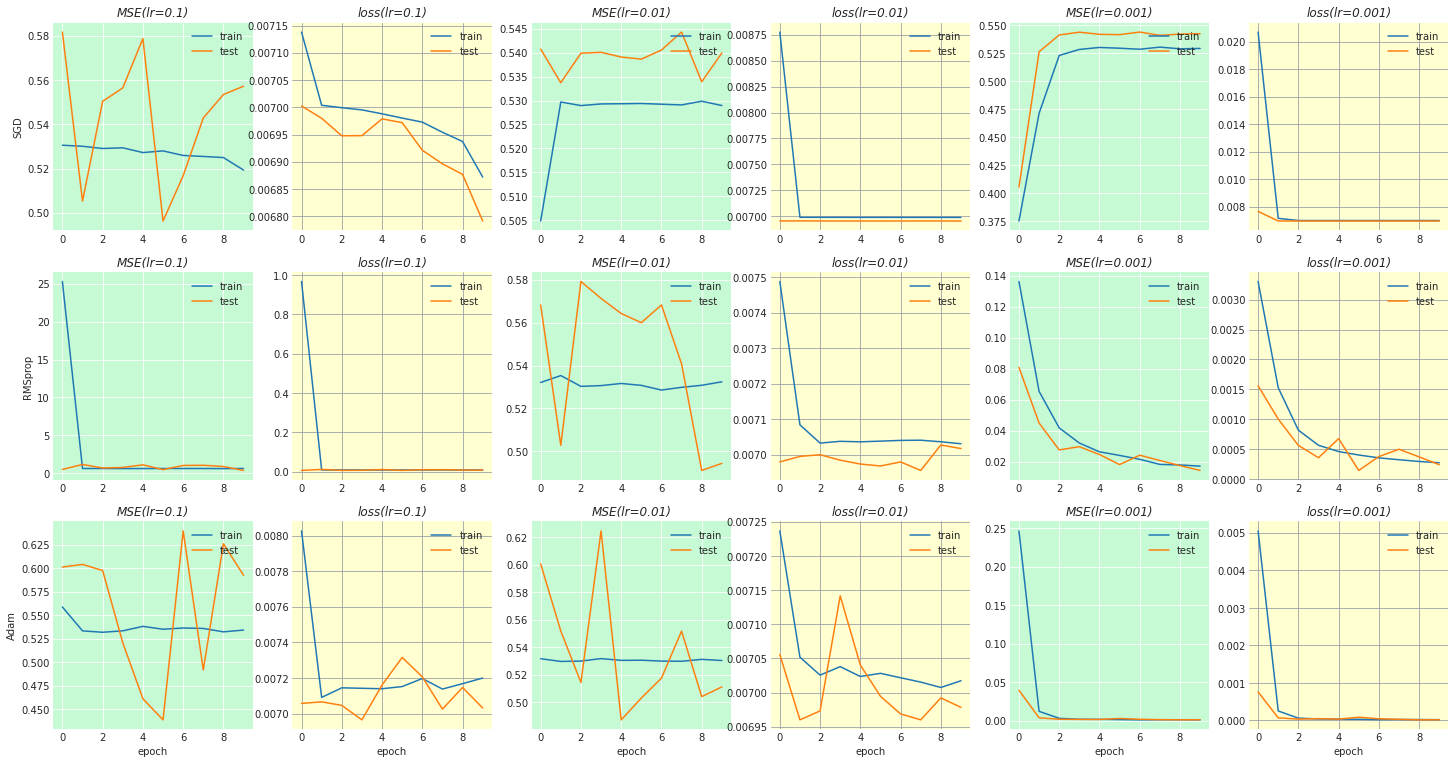

In [52]:
for i in range(3):
    build_learning_curves_family(DNNs[i * 9:(i + 1) * 9])

# Conclusion

9.1. As we can see the best result has the model with following hyperparameters:
1.   5 hidden layers
2.   Adam optimizer
3.   learning rate equals 0.01

To my mind is no exact explanation why it is the best result. Actually it depends on what dataset we have, how huge is test dataset and how many epochs model had been training. So for current data this DNN works best.

9.2.  Optimization algorithms or strategies are responsible for reducing the losses and to provide the most accurate results possible. In our case in almost all expreiments Adam worked better then others

9.3.  The learning rate controls how quickly the model is adapted to the problem. Smaller learning rates require more training epochs given the smaller changes made to the weights each update(*This is why we got bad results using small learning rate with all optimizers as we had only 10 epochs*), whereas larger learning rates result in rapid changes and require fewer training epochs.
As a result - excellent learning curves.

9.4.  DNN architecture also depends as not enough number of hidden layers can cause bad training and a lot of ones leads to overfitting. For our regression problem the optimum number of hidden layers is 5.

9.5.  Data distribution is the key aspect for choosing trainig model. If we had trully linear distribution, Linear Regression model would give us enough exact prediction in the shortest time. But more complex models worked much more better, so our distribution turned out non-linear. 